### **Импорты**

In [1]:
import pandas as pd
!pip install datasets --quiet
from datasets import load_dataset
from collections import Counter
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


### **Загрузка датасета**

Набор данных "web_questions" является набором вопросов, связанных с веб-поиском. Каждый пример представляет собой вопрос, ответ и ссылку.

In [2]:
dataset = load_dataset("web_questions")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3778 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2032 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['url', 'question', 'answers'],
        num_rows: 3778
    })
    test: Dataset({
        features: ['url', 'question', 'answers'],
        num_rows: 2032
    })
})

### **Предобработка датасета**

In [3]:
data = pd.concat([
    pd.DataFrame(dataset['train']),
    pd.DataFrame(dataset['test'])
], axis=0)
data = data.drop(columns=['url'])
data: list[str, list[str]] = data.values.tolist()
print(data[:1])

[['what is the name of justin bieber brother?', ['Jazmyn Bieber', 'Jaxon Bieber']]]


In [4]:
print(data[:10])

[['what is the name of justin bieber brother?', ['Jazmyn Bieber', 'Jaxon Bieber']], ['what character did natalie portman play in star wars?', ['Padmé Amidala']], ['what state does selena gomez?', ['New York City']], ['what country is the grand bahama island in?', ['Bahamas']], ['what kind of money to take to bahamas?', ['Bahamian dollar']], ['what character did john noble play in lord of the rings?', ['Denethor II']], ['who does joakim noah play for?', ['Chicago Bulls']], ['where are the nfl redskins from?', ['Washington Redskins']], ['where did saki live?', ['United Kingdom']], ['how old is sacha baron cohen?', ['http://justjared.buzznet.com/2009/01/12/sacha-baron-cohen-insults-madonna-at-golden-globes/']]]


Теперь каждый элемент списка представляет собой пару, где первый элемент - это вопрос (строка), а второй элемент - это список строк, представляющий ответы на этот вопрос.

### Визуализация графа знаний

In [11]:
def get_graph(data: list[str, list[str]]) -> nx.MultiDiGraph:
    """Построение графа знаний"""
    G = nx.MultiDiGraph()
    for elem in data:
        question = elem[0].split()
        entity1 = question[0]
        entity2 = question[1]
        question = ' '.join(question[2:])
        if len(elem[1]) == 1:
            answer = elem[1][0]
            G.add_node(entity1, size=1400, color='blue', font_size=12)
            G.add_node(answer, size=900, color='orange', font_size=8)
            G.add_node(question, size=300, color='red', font_size=10)
            G.add_edge(entity1, question, label=entity2)
            G.add_edge(question, answer)
        else:
            for answer in elem[1]:
                G.add_node(entity1, size=1200, color='purple', font_size=14)
                G.add_node(answer, size=800, color='green', font_size=10)
                G.add_node(question, size=400, color='grey', font_size=12)
                G.add_edge(entity1, question, label=entity2)
                G.add_edge(question, answer)
    return G

In [12]:
def build_graph(G: nx.MultiDiGraph) -> None:
    """Визуализация графа знаний"""
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G)

    edge_labels = nx.get_edge_attributes(G, 'label')
    node_sizes = [nx.get_node_attributes(G, 'size')[node]
                for node in G.nodes()]
    node_colors = [nx.get_node_attributes(G, 'color')[node]
                for node in G.nodes()]
    font_sizes = [nx.get_node_attributes(G, 'font_size')[node]
                for node in G.nodes()]

    nx.draw(G, with_labels=False, pos=pos, node_size=node_sizes,
            node_color=node_colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    for node, (x, y) in pos.items():
        plt.text(x, y, s=node, horizontalalignment='center',
                fontsize=nx.get_node_attributes(G, 'font_size')[node])
    plt.show()

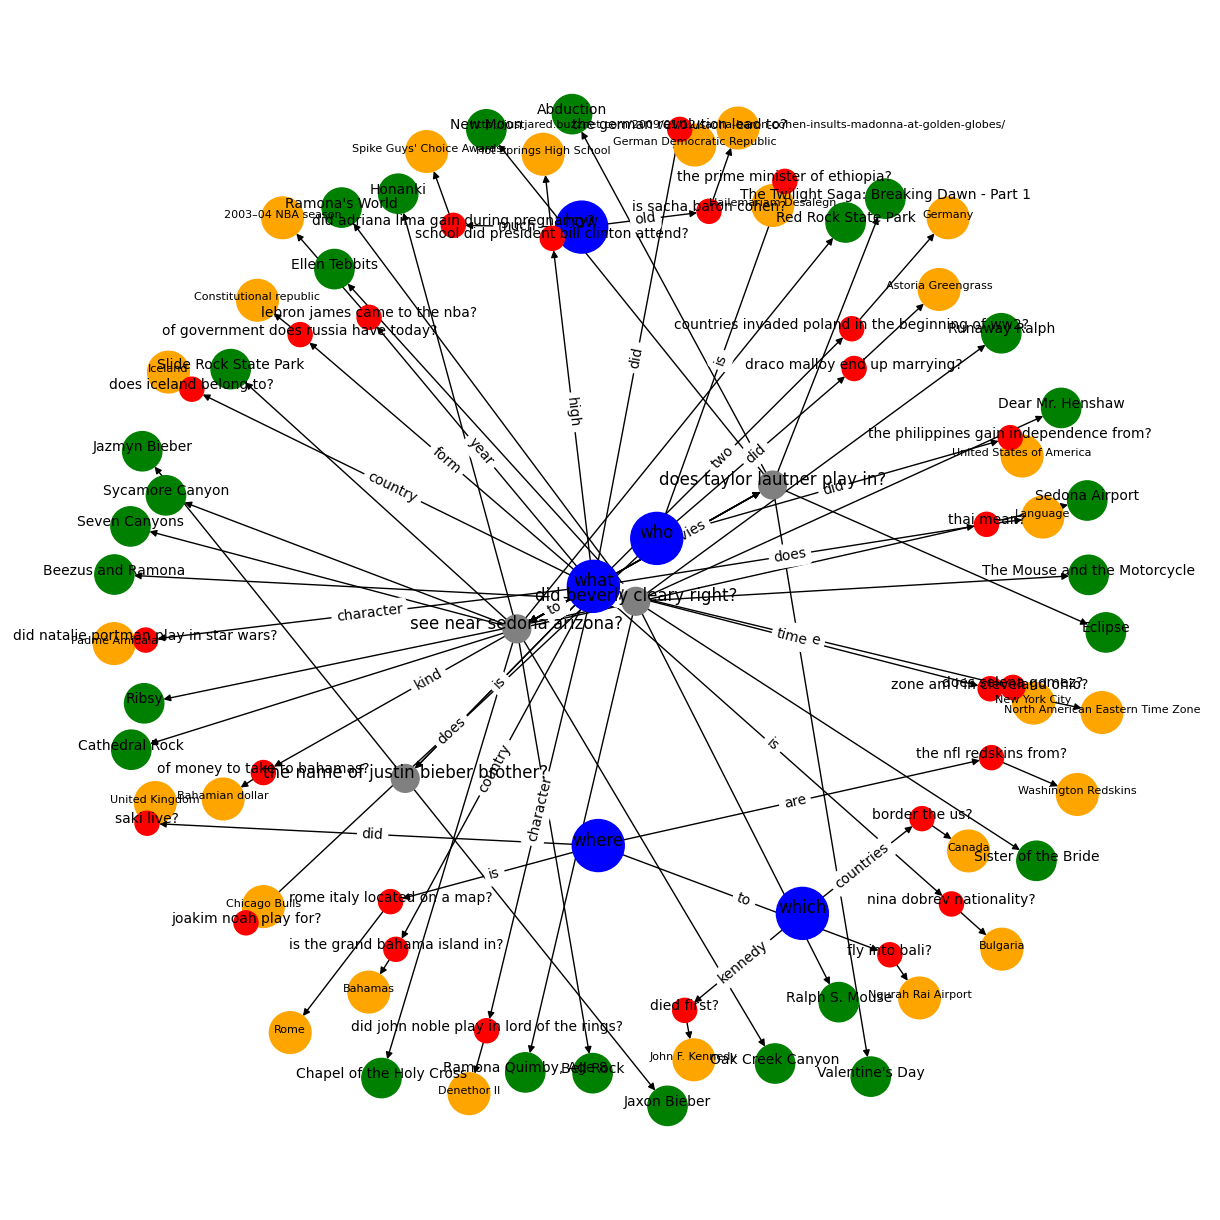

In [13]:
build_graph(get_graph(data[:30]))

In [14]:
def find_answer(data: list[str, list[str]], question: str) -> None:
    """Функция поиска по графу ответа на введённый вопрос"""
    question = question.lower()
    words = question.split()
    len_q = len(words)

    data_to_show = []  # список данных, которые соответствуют условиям поиска

    if len_q == 1:
        for elem in data:
            if elem[0].lower().startswith(words[0]):
                data_to_show.append(elem)
        if len(data_to_show) == 0:  # проверка, начинается ли первое слово вопроса с текущего элемента
            for elem in data:
                if words[0] in elem[0].lower():
                    data_to_show.append(elem)
            print("Поиск по слову в вопросе")
        else:
            print("Поиск по первому ключевому слову")

    elif len_q == 2:
        for elem in data:
            # проверка, совпадает ли первая пара слов в вопросе из текущего элемента с введенным вопросом
            if ' '.join(elem[0].lower().split()[:2]) == question:
                data_to_show.append(elem)
        if len(data_to_show) == 0:
            for elem in data:
                if question in elem[0].lower():
                    data_to_show.append(elem)
            print("Поиск по двум словам в вопросе")
        else:
            print("Поиск по первым двум ключевым словам")

    elif len_q >= 3:
        for elem in data:
            # проверка, насколько похожи вопрос из текущего элемента и введенный вопрос
            if SequenceMatcher(None, elem[0], question).ratio() >= .75:
                data_to_show.append(elem)
        if len(data_to_show) == 0:
            for elem in data:
                if question in elem[0].lower():
                    data_to_show.append(elem)
            print("Поиск по последовательности слов в вопросе")
        else:
            print("Поиск по близости строк")

    build_graph(get_graph(data_to_show))

Поиск по первому ключевому слову


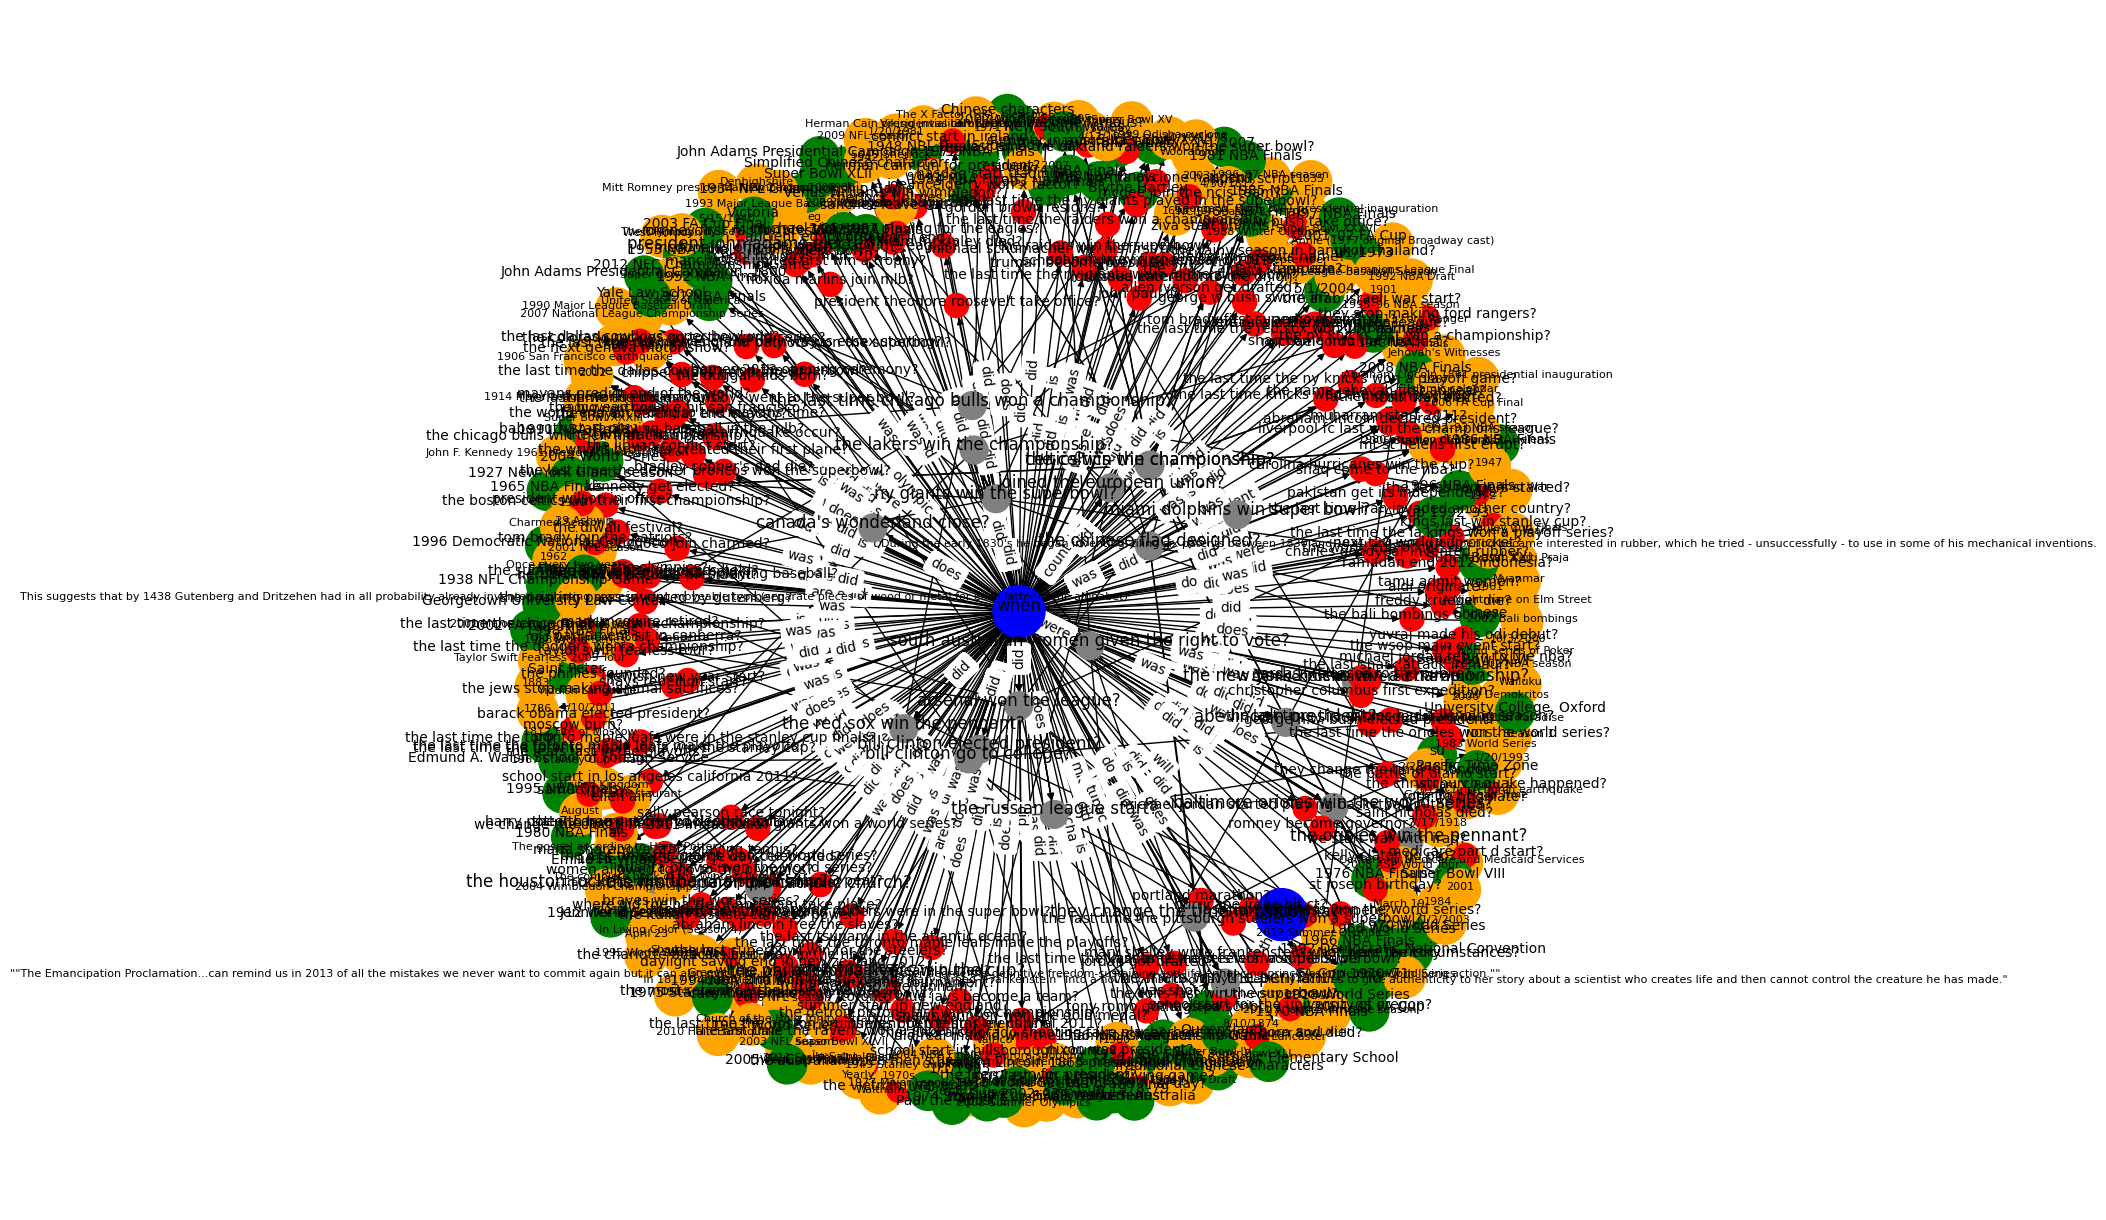

In [30]:
find_answer(data, "When")

Поиск по первым двум ключевым словам


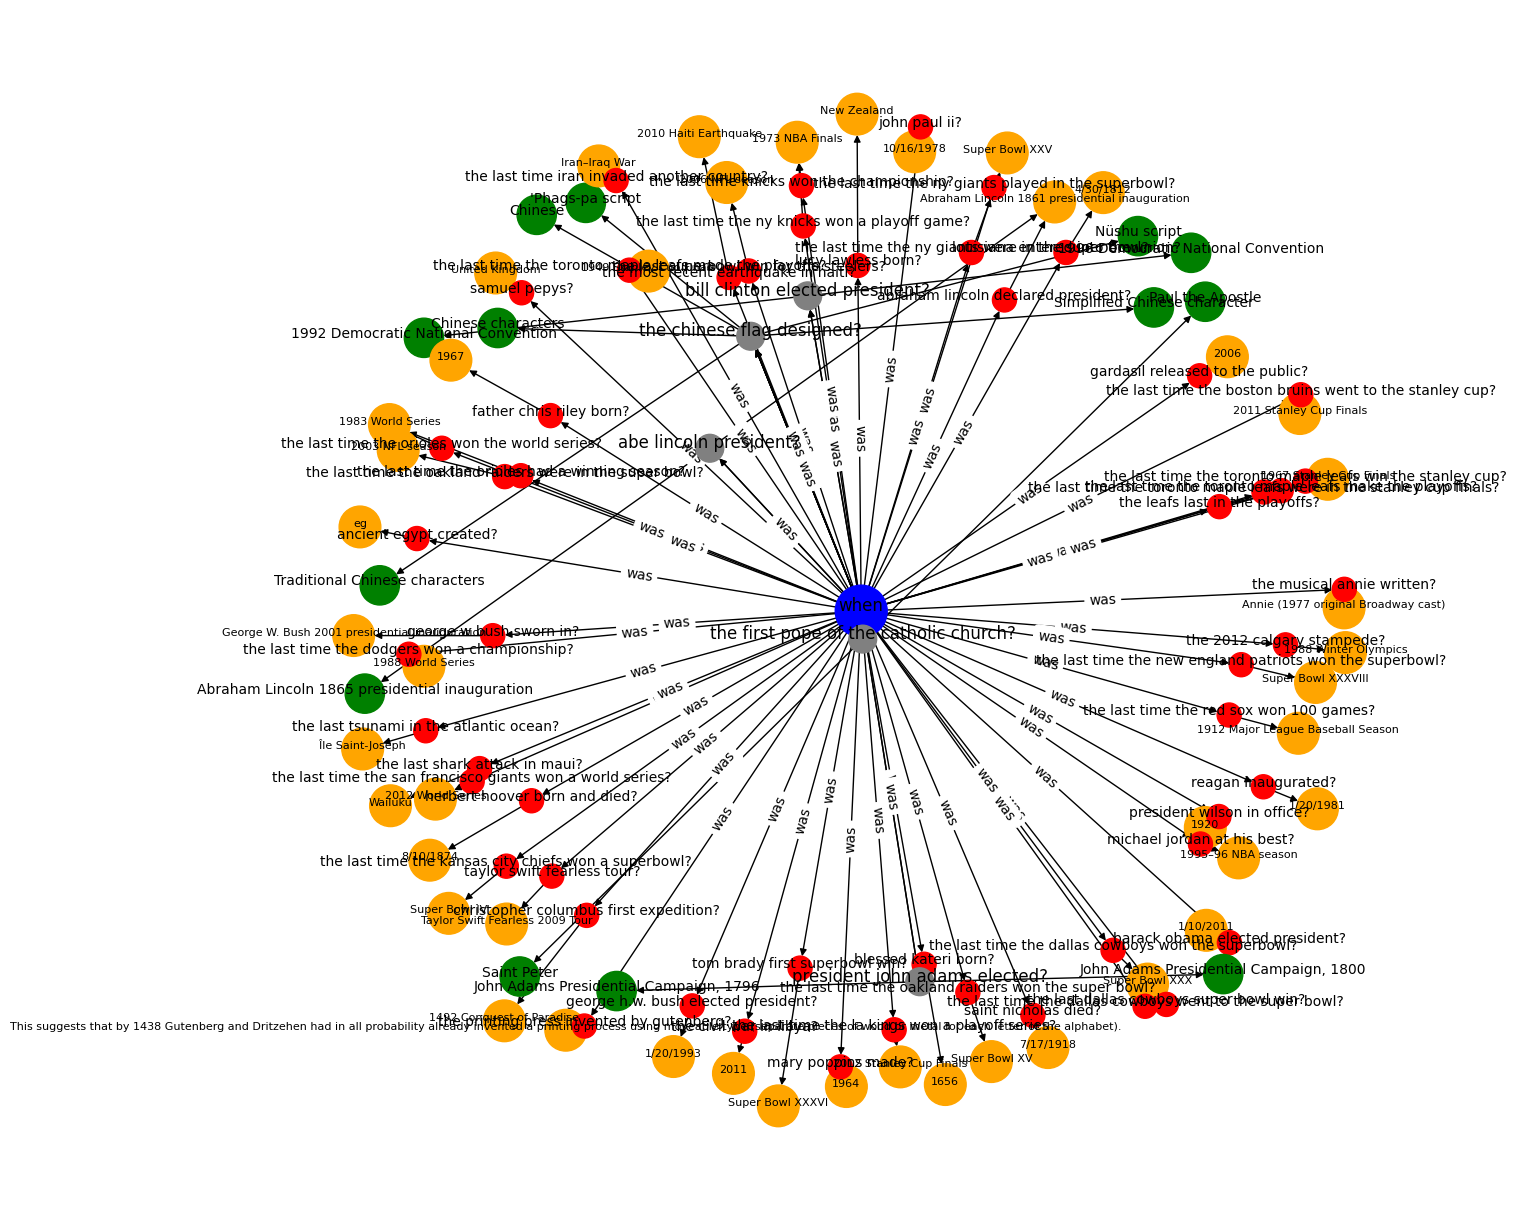

In [31]:
find_answer(data, "When was")

Поиск по последовательности слов в вопросе


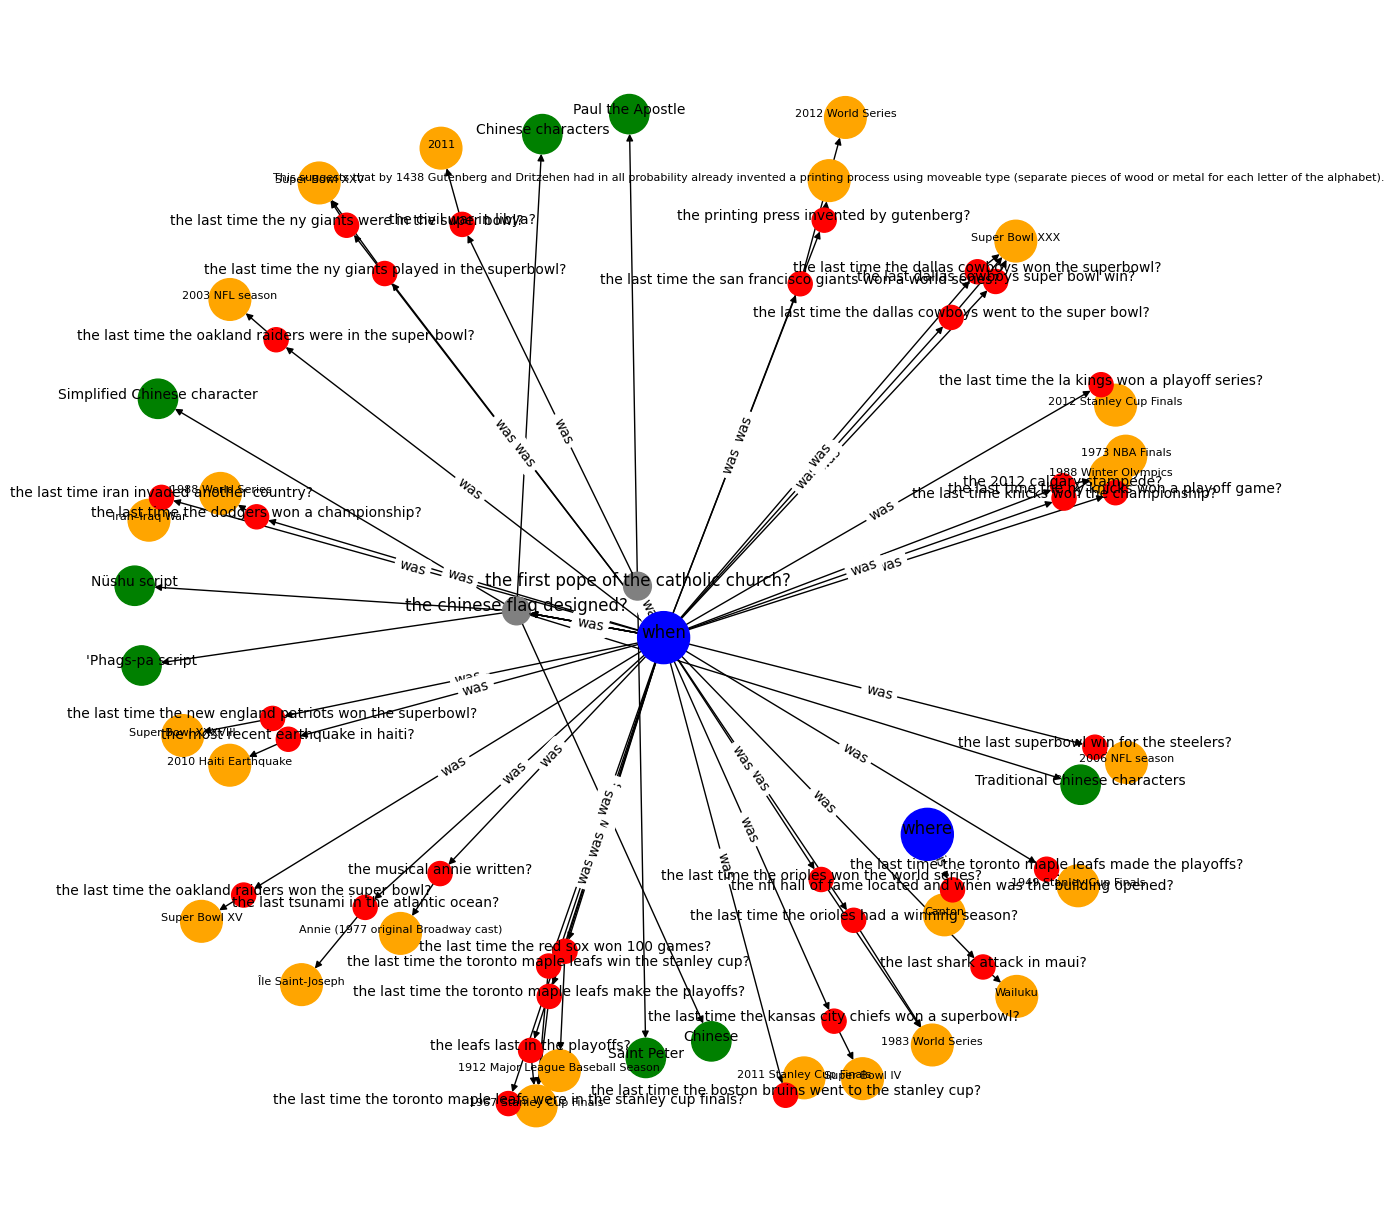

In [29]:
find_answer(data, "When was the")